# Preprocessing

This notebook contains some general preprocessing steps that are usefull regardless of the model approach. The resulting datasets are stored and can be used for training and evaluation.

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Load Data

In [2]:
# download dataset
# !curl -X GET https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o data/video_games.tsv.gz

In [3]:
# read data into pandas dataframe
path = "data/video_games.tsv.gz"
data_raw = pd.read_csv(path, sep="\t", parse_dates=[14], on_bad_lines="skip")
data_raw.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


### General Preprocessing
Some general steps to further work with the data:
* only use last two years of reviews, as the data set is very large and these are the most recent reviews
* only use relevant columns, including the review headline, body and the star ratings
* if the user did not write a headline for his review, Amazon automatically inserts the star ratings written out ("Five Stars", etc...) as a default headline. As this could be a false predictors for our model training, we filter these headlines by replacing with empty strings
* concatenate the review headline and body

In [4]:
video_games = data_raw.copy()

# filter by last two years based on review_date
video_games['review_date'] = pd.to_datetime(video_games['review_date'])
video_games = video_games[video_games['review_date'] >= datetime(2015, 1, 1)] # 8 months - maybe we need a full year? If so, we need to sample stratified from 2014-8-31

# use only relevant columns
video_games = video_games[["review_headline", "review_body", "star_rating"]]

# replace default star rating in headline with empty string as these could be false predictors
mask = video_games['review_headline'].isin(['One Star', 'Two Stars', 'Three Stars', 'Four Stars', 'Five Stars'])
video_games['review_headline'][mask] = ''

# concat headline and review body
video_games['full_review'] = video_games['review_headline'] + ' ' + video_games['review_body']
video_games = video_games[['full_review', 'star_rating']]
video_games.head()

,full_review,star_rating
0,an amazing joystick. I especially love that yo...,5
1,Definitely a silent mouse... Not a single clic...,5
2,poor quality work and not as it is advertised.,1
3,"good, but could be bettee nice, but tend to sl...",3
4,"Great but flawed. Great amiibo, great for coll...",4


### Train-Test Split

Split data into seperate train and test split. The test size is not really relevant, as we have enough data and the training data will be further subsampled in the following steeps.

In [5]:
train_df, test_df = train_test_split(video_games, test_size=0.5, stratify=video_games['star_rating'])
print(f'Train Split size: {len(train_df)}')
print(f'Test Split size: {len(test_df)}')

Train Split size: 165483
Test Split size: 165483


### Subsampling

With subsampling we limit the amount of data used for training due to processing power and model training time, as the original dataset has a lot of entries, even after splitting in train and test set. The sampling is both done in a stratified and balanced fashion, to evaluate the effects on model effectivity with the different sampling methods. No subsampling is done on the test set, to prevent any bias in model evaluation.

In [6]:
# Define the desired sampling size
sample_size = 30000

#### Stratified Sample
Stratified Sample where the data distribution with respect to the star ratings is preserved

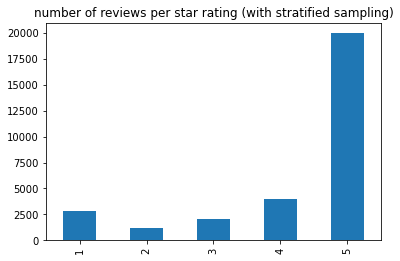

In [7]:
# Create a StratifiedShuffleSplit object
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Generate the indices for stratified sampling
indices = stratified_split.split(train_df, train_df['star_rating'])

# Extract the indices for the sampled records
sampled_indices = next(indices)[1]

# Create the sampled DataFrame based on the indices
train_df_stratified = train_df.iloc[sampled_indices].reset_index(drop=False)


# bar plot number of reviews per star rating
train_df_stratified["star_rating"].value_counts().sort_index().plot(kind="bar", title="number of reviews per star rating (with stratified sampling)")
plt.show()

#### Balanced Sample

Balanced Sample where the data distribution with respect to the star ratings is preserved, so that each class of star ratings has an equal amount of examples

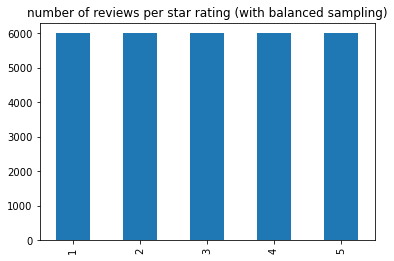

In [8]:
ratings = train_df['star_rating'].unique()
train_df_balanced = pd.DataFrame([])

# divide dataset into five equally large samples for every rating
for rating in ratings:
  tmp = train_df[train_df['star_rating'] == rating].sample(int(sample_size/5), random_state= 42)
  train_df_balanced = pd.concat([train_df_balanced, tmp])

    
# bar plot number of reviews per star rating
train_df_balanced["star_rating"].value_counts().sort_index().plot(kind="bar", title="number of reviews per star rating (with balanced sampling)")
plt.show()

### Train-Validation Split
The training data is further split into a validation set with size 0.3 for model learning and hyperparameter tuning

In [9]:
# create train and validation split (on balanced subsample)
train_df_balanced, val_df_balanced = train_test_split(train_df_balanced, test_size=0.3)

# create train and validation split (on stratified subsample)
train_df_stratified, val_df_stratified = train_test_split(train_df_stratified, test_size=0.3)

print(f'Test Split size: {len(test_df)}')
print()
print('------- Balanced Sample -------')
print(f'Train Split size: {len(train_df_balanced)}')
print(f'Validation Split size: {len(val_df_balanced)}')
print()
print('------ Stratified Sample ------')
print(f'Train Split size: {len(train_df_stratified)}')
print(f'Validation Split size: {len(val_df_stratified)}')

Test Split size: 165483

------- Balanced Sample -------
Train Split size: 21000
Validation Split size: 9000

------ Stratified Sample ------
Train Split size: 21000
Validation Split size: 9000


### Store Data

To ensure comparability and reproducability with different model approaches, the test set and validation and trainings sets are stored and later used in training.

In [10]:
# store balanced train and validation sets
train_df_balanced.to_csv('data/balanced/train_balanced.csv', index=False)
val_df_balanced.to_csv('data/balanced/val_balanced.csv', index=False)

# store stratified train and validation sets
train_df_stratified.to_csv('data/stratified/train_stratified.csv', index=False)
val_df_stratified.to_csv('data/stratified/val_stratified.csv', index=False)

# store test set
test_df.to_csv('data/test.csv', index=False)